In [12]:
base = '/home3/ebrahim/what-is-brainscore/'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.metrics import mean_squared_error
import sys
sys.path.append(f'f{base}')
from plotting_functions import plot_test_perf_across_layers, plot_across_subjects, save_fMRI_simple, single_seed_mse_r2, find_rows_without_nan, pass_info_plot_hist2d
from untrained_results_funcs import compute_p_val, arrange_pvals_pd, remove_neg_r2, voxel_corrected_LLM_nested_full, mse_max_model, pool_across_seeds
from scipy.stats import pearsonr
import seaborn as sns
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib
from scipy.stats import ttest_rel, ttest_1samp
import statsmodels.formula.api as smf
import nibabel as nib
from nilearn import plotting
from nilearn import surface
from nilearn import datasets
import plotly
import brainio
from matplotlib import pyplot as plt
from netCDF4 import Dataset

from scipy.stats import wilcoxon

In [14]:
data_processed_folder = f'{base}data_processed/pereira/'

In [15]:
model_name = 'gpt2-xl'
sp_str = '-sp' # set to empty to load last token model
N = 10 # number of random seeds

In [16]:
# load important things
figurePath = '/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/figures/pereira_untrained_obi/'
resultsFolder = f'{base}results_all/results_pereira/untrained/'
dataset = 'pereira'

In [17]:
exp = ['both', '243', '384']
br_labels_dict = {}
num_vox_dict = {}
ytest_dict = {}
mse_intercept_dict = {}
subjects_dict = {}
for e in exp:
    bre = np.load(f'{base}/pereira_data/networks_{e}.npy', allow_pickle=True)
    br_labels_dict[e] = bre
    num_vox_dict[e] = bre.shape[0]
    mse_intercept_dict[e] = np.load(f'/home3/ebrahim/what-is-brainscore/results_all/results_pereira/mse_intercept_{e}.npy')
    ytest_dict[e] = np.load(f'/home3/ebrahim/what-is-brainscore/results_all/results_pereira/y_test_ordered_{e}.npy')
    subjects_dict[e] = np.load(f"{data_processed_folder}/subjects_{e}.npy", allow_pickle=True)

In [18]:
def load_best_layer(exp, model_name, N, sp_str):
    best_layer = []
    best_layer_lang = []
    for i in range(N):
        keys = list(dict(np.load(f'/home3/ebrahim/what-is-brainscore/data_processed/pereira/X_{model_name}-untrained{sp_str}-{exp}_m{i}.npz')).keys())
        bil_all = [k for k in keys if 'all' in k][0]
        bil_lang = [k for k in keys if 'lang' in k][0]
        best_layer.append(bil_all)
        best_layer_lang.append(bil_lang.replace('_lang', ''))
        
    return best_layer, best_layer_lang

_, bl_lang_243 = load_best_layer('243', model_name, N, sp_str)
_, bl_lang_384 = load_best_layer('384', model_name, N, sp_str)

### Across layer performance

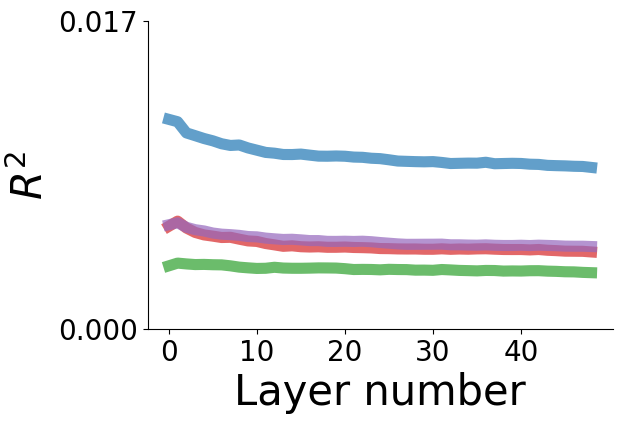

In [40]:
N = 10
yticks=[]
networks = ['language', 'DMN', 'MD', 'visual']
model_names = [f'gpt2-xl-untrained{sp_str}' for i in range(N)]
layers_range = [[0,48] for i in range(N)]
layer_name_arr = [f'layer_' for i in range(0,48)]
model_nums = np.arange(N)
colors = {}
colors_arr = ['tab:blue', 'tab:green', 'tab:red', 'tab:purple', 'tab:orange']
for i, n in enumerate(networks):
    colors[n] = colors_arr[i]
res_pd_384 = plot_test_perf_across_layers(model_names, dataset='pereira', layers_range=layers_range,
                             layer_name_arr=layer_name_arr, saveName='gpt2l-ut_perf_across_layers_384', 
                             figurePath=figurePath, resultsFolder=resultsFolder, yticks=[0, .017], exp='384', 
                             model_nums=model_nums,
                             networks=networks, br_labels=br_labels_dict['384'], 
                             subjects=subjects_dict['384'], colors=colors, plot_legend=True, gpt_sp_perf=None)



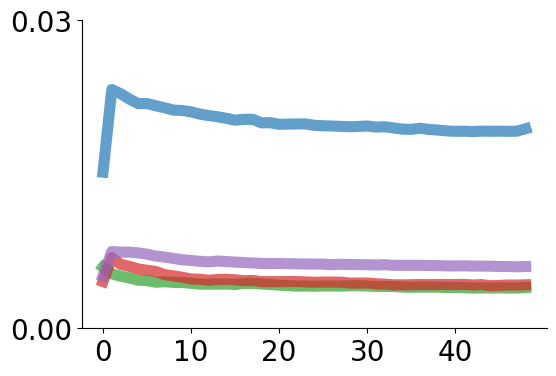

In [26]:
res_pd_243 = plot_test_perf_across_layers(model_names, dataset='pereira', layers_range=layers_range,
                             layer_name_arr=layer_name_arr, saveName='gpt2l-ut_perf_across_layers_243', 
                             figurePath=figurePath, resultsFolder=resultsFolder, yticks=[0, 0.03], exp='243', 
                             model_nums=model_nums,ylabel=False, xlabel=False, 
                             networks=networks, br_labels=br_labels_dict['243'], 
                             subjects=subjects_dict['243'], colors=colors, plot_legend=False, gpt_sp_perf=None)

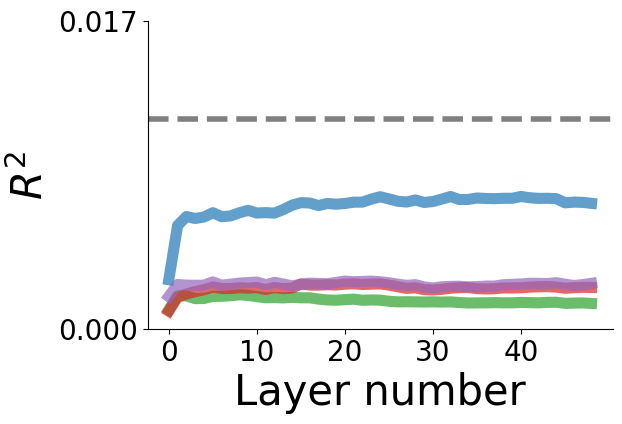

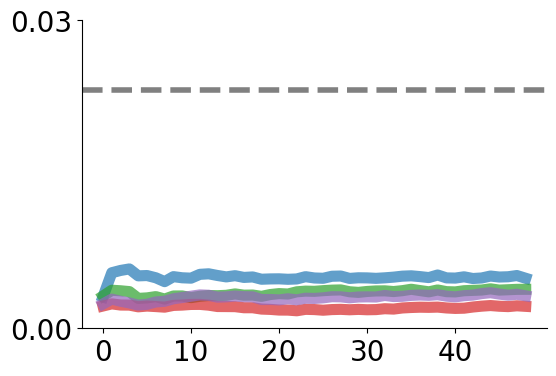

In [30]:
# plot last token results 

model_names = [f'gpt2-xl-untrained' for i in range(N)]

gpt2_sp_384_max = np.max(res_pd_384.loc[res_pd_384.Network=='language'].r2.values)
gpt2_sp_243_max = np.max(res_pd_243.loc[res_pd_243.Network=='language'].r2.values)

res_pd_384 = plot_test_perf_across_layers(model_names, dataset='pereira', layers_range=layers_range,
                             layer_name_arr=layer_name_arr, saveName='gpt2l-ut_lt_perf_across_layers_384', 
                             figurePath=figurePath, resultsFolder=resultsFolder, yticks=[0, .017], exp='384', 
                             model_nums=model_nums,
                             networks=networks, br_labels=br_labels_dict['384'], 
                             subjects=subjects_dict['384'], colors=colors, plot_legend=False, gpt_sp_perf=gpt2_sp_384_max)
res_pd_243 = plot_test_perf_across_layers(model_names, dataset='pereira', layers_range=layers_range,
                             layer_name_arr=layer_name_arr, saveName='gpt2l-ut_lt_perf_across_layers_243', 
                             figurePath=figurePath, resultsFolder=resultsFolder, yticks=[0, 0.03], exp='243', 
                             model_nums=model_nums,ylabel=False, xlabel=False, 
                             networks=networks, br_labels=br_labels_dict['243'], 
                             subjects=subjects_dict['243'], colors=colors, plot_legend=False, gpt_sp_perf=gpt2_sp_243_max)

### Load pooled mse and r2

In [19]:
# load mse value for BIL only model
mse_bil_243, r2_bil_243 = pool_across_seeds(ytest_dict['243'],np.repeat('gpt2-xl-untrained-sp', N), np.repeat('243', N), 
                                              bl_lang_243, niters=np.repeat(1,N), resultsFolder=resultsFolder)
mse_bil_384, r2_bil_384 = pool_across_seeds(ytest_dict['384'],np.repeat('gpt2-xl-untrained-sp', N), np.repeat('384', N), 
                                              bl_lang_384, niters=np.repeat(1,N), resultsFolder=resultsFolder)

# load mse value for BIL only model
mse_bil_PW_243, r2_bil_PW_243 = pool_across_seeds(ytest_dict['243'],np.repeat('gpt2-xl-ut_bil-lang_POSWN', N), np.repeat('243', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=resultsFolder, seed_last=False)
mse_bil_PW_384, r2_bil_PW_384 = pool_across_seeds(ytest_dict['384'],np.repeat('gpt2-xl-ut_bil-lang_POSWN', N), np.repeat('384', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=resultsFolder, seed_last=False)

# load mse value for BIL only model
mse_bil_W_243, r2_bil_W_243 = pool_across_seeds(ytest_dict['243'],np.repeat('gpt2-xl-ut_bil-lang_WN', N), np.repeat('243', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=resultsFolder, seed_last=False)
mse_bil_W_384, r2_bil_W_384 = pool_across_seeds(ytest_dict['384'],np.repeat('gpt2-xl-ut_bil-lang_WN', N), np.repeat('384', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=resultsFolder, seed_last=False)

# load mse value for BIL only model
mse_bil_P_243, r2_bil_P_243 = pool_across_seeds(ytest_dict['243'],np.repeat('gpt2-xl-ut_bil-lang_POS', N), np.repeat('243', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=resultsFolder, seed_last=False)
mse_bil_P_384, r2_bil_P_384 = pool_across_seeds(ytest_dict['384'],np.repeat('gpt2-xl-ut_bil-lang_POS', N), np.repeat('384', N), 
                                              np.repeat('layer1', N), niters=np.repeat(1000,N), resultsFolder=resultsFolder, seed_last=False)

# load non BIL models 
mse_PW_243, r2_PW_243 = single_seed_mse_r2(ytest_dict['243'], 'positional_WN', niters=1000, exp='243', layer_name='layer1', resultsFolder=resultsFolder)
mse_PW_384, r2_PW_384 = single_seed_mse_r2(ytest_dict['384'], 'positional_WN', niters=1000, exp='384', layer_name='layer1', resultsFolder=resultsFolder)

mse_P_243, r2_P_243 = single_seed_mse_r2(ytest_dict['243'], 'positional_simple', niters=1, exp='243', layer_name='layer1', resultsFolder=resultsFolder)
mse_P_384, r2_P_384 = single_seed_mse_r2(ytest_dict['384'], 'positional_simple', niters=1, exp='384', layer_name='layer1', resultsFolder=resultsFolder)

mse_W_243, r2_W_243 = single_seed_mse_r2(ytest_dict['243'], 'word-num', niters=1, exp='243', layer_name='layer1', resultsFolder=resultsFolder)
mse_W_384, r2_W_384 = single_seed_mse_r2(ytest_dict['384'], 'word-num', niters=1, exp='384', layer_name='layer1', resultsFolder=resultsFolder)

In [9]:
non_nan_384 = find_rows_without_nan(np.vstack((r2_W_384, r2_P_384, r2_PW_384, r2_bil_384, r2_bil_W_384, r2_bil_P_384, r2_bil_PW_384)))
non_nan_243 = find_rows_without_nan(np.vstack((r2_W_243, r2_P_243, r2_PW_243, r2_bil_243, r2_bil_W_243, r2_bil_P_243, r2_bil_PW_243)))

In [12]:
# store r2 valeus into a pd dataframe
model_names = ['SL', 'SP', 'SP+SL', 'GPT2-XLU', 'SL+GPT2-XLU', 'SP+GPT2-XLU', 'SP+SL+GPT2-XLU']
best_DEM_model = model_names[2]
best_LLM_model = model_names[-1]
LLM_name = model_names[3]
num_models = len(model_names)
voxels_ids_243 = np.tile(np.arange(num_vox_dict['243']), num_models)
br_labels_243 = np.tile(br_labels_dict['243'], num_models)
model_order_243 = np.repeat(np.array(model_names), num_vox_dict['243'])

r2_stacked_243 = np.concatenate((r2_W_243, r2_P_243, r2_PW_243, r2_bil_243, r2_bil_W_243, r2_bil_P_243, r2_bil_PW_243))
r2_stacked_pd_243 = pd.DataFrame({'Model': model_order_243, 'r2':r2_stacked_243, 'voxel_id': voxels_ids_243, 
                                  'Network': br_labels_243, 'subjects': np.tile(subjects_dict['243'], num_models)}).dropna()


voxels_ids_384 = np.tile(np.arange(num_vox_dict['384']), num_models)
br_labels_384 = np.tile(br_labels_dict['384'], num_models)
model_order_384 = np.repeat(np.array(model_names), num_vox_dict['384'])
r2_stacked_384 = np.concatenate((r2_W_384, r2_P_384, r2_PW_384, r2_bil_384, r2_bil_W_384, r2_bil_P_384, r2_bil_PW_384))

r2_stacked_pd_384 = pd.DataFrame({'Model': model_order_384, 'r2':r2_stacked_384, 'voxel_id': voxels_ids_384, 
                                   'Network': br_labels_384, 
                                   'subjects': np.tile(subjects_dict['384'], num_models)}).dropna()


network_order=['language', 'DMN', 'MD', 'visual']

<Figure size 640x480 with 0 Axes>

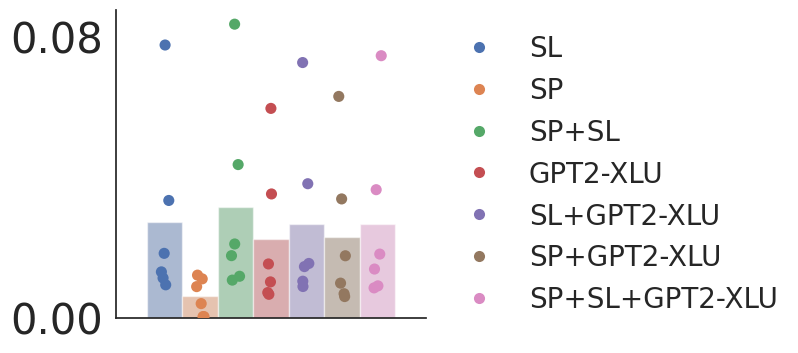

In [13]:
subj_avg_pd_243, _, _ = plot_across_subjects(r2_stacked_pd_243.copy(), selected_networks=['language'],
                                             figurePath=figurePath, 
                                             saveName='243_across_subjects_xl_untrained', hue_order=model_names, yticks=[0,0.08], 
                                                order=['language'], clip_zero=True, plot_legend=True, ylabel=False, width=0.8, ms=8)

In [14]:
subj_avg_pd_243_ri = subj_avg_pd_243.reset_index()
subj_avg_pd_243_ri = subj_avg_pd_243_ri.drop(columns=['voxel_id'])
subj_243_lang = subj_avg_pd_243_ri.loc[subj_avg_pd_243_ri.Network=='language']
filtered_df = subj_243_lang[(subj_243_lang['Model'].isin([best_DEM_model, best_LLM_model]))]
filtered_df

,subjects,Network,Model,r2
5,018,language,SP+SL,0.020953
6,018,language,SP+SL+GPT2-XLU,0.018068
12,215,language,SP+SL,0.011751
13,215,language,SP+SL+GPT2-XLU,0.009020
19,288,language,SP+SL,0.017623
20,288,language,SP+SL+GPT2-XLU,0.013804
26,289,language,SP+SL,0.043573
27,289,language,SP+SL+GPT2-XLU,0.036420
33,296,language,SP+SL,0.010654
34,296,language,SP+SL+GPT2-XLU,0.008439


<Figure size 640x480 with 0 Axes>

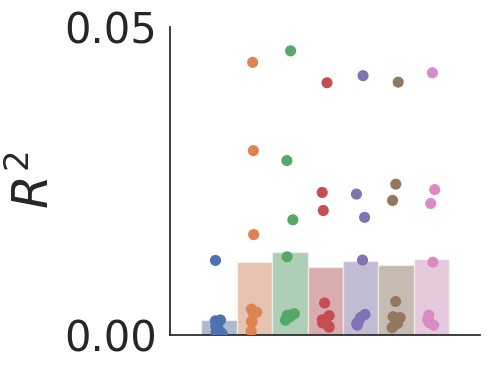

In [15]:
subj_avg_pd_384, _, _ = plot_across_subjects(r2_stacked_pd_384.copy(), selected_networks=['language'],
                                             figurePath=figurePath, 
                                             saveName='384_across_subjects_xl_untrained', hue_order=model_names, yticks=[0,0.05], 
                                                order=['language'], clip_zero=True, plot_legend=False, width=0.8, ms=8)

In [16]:
subj_avg_pd_384_ri = subj_avg_pd_384.reset_index()
subj_avg_pd_384_ri = subj_avg_pd_384_ri.drop(columns=['voxel_id'])
subj_384_lang = subj_avg_pd_384_ri.loc[subj_avg_pd_384_ri.Network=='language']
filtered_df = subj_384_lang[(subj_384_lang['Model'].isin([best_DEM_model, best_LLM_model]))]
filtered_df

,subjects,Network,Model,r2
5,018,language,SP+SL,0.012613
6,018,language,SP+SL+GPT2-XLU,0.011737
12,199,language,SP+SL,0.002842
13,199,language,SP+SL+GPT2-XLU,0.001502
19,288,language,SP+SL,0.002320
20,288,language,SP+SL+GPT2-XLU,0.002415
26,289,language,SP+SL,0.028237
27,289,language,SP+SL+GPT2-XLU,0.023523
33,296,language,SP+SL,0.003103
34,296,language,SP+SL+GPT2-XLU,0.003133


0.955**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ax.get_xlim(), ax.get_ylim(), 'r--', alpha=0.75, color='black')


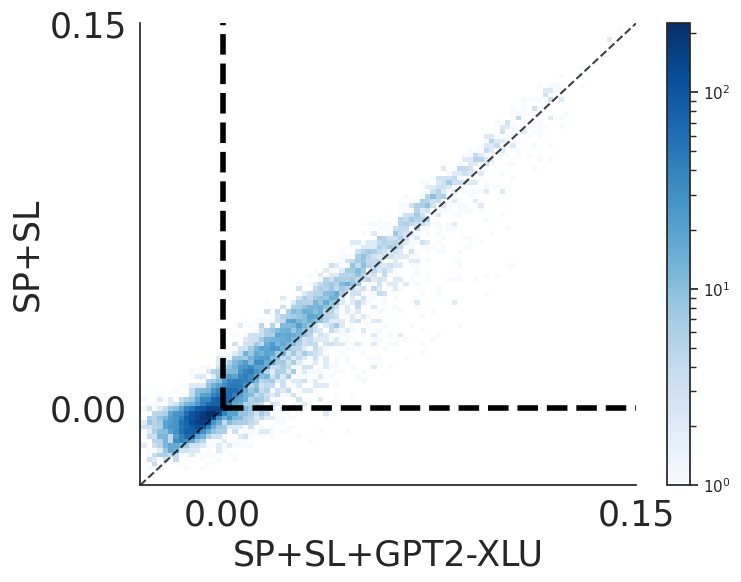

0.918**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ax.get_xlim(), ax.get_ylim(), 'r--', alpha=0.75, color='black')


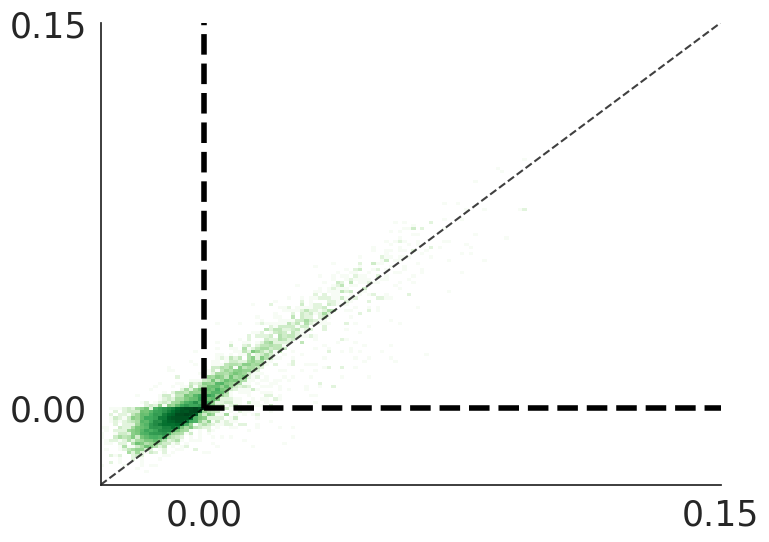

0.909**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ax.get_xlim(), ax.get_ylim(), 'r--', alpha=0.75, color='black')


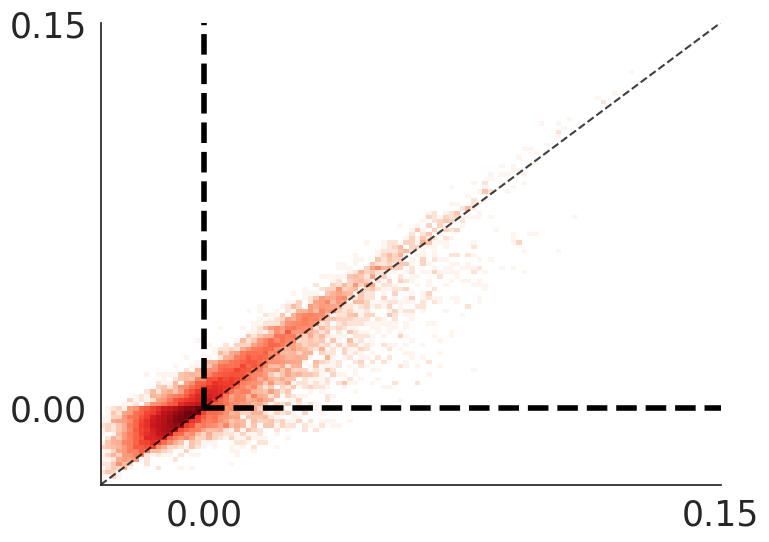

0.923**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ax.get_xlim(), ax.get_ylim(), 'r--', alpha=0.75, color='black')


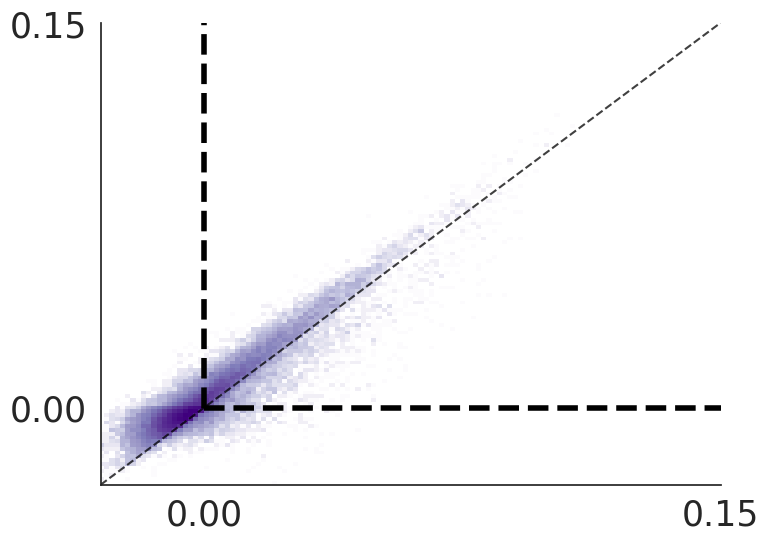

In [16]:
pass_info_plot_hist2d(max_val_dict={'language': 0.15, 'DMN': 0.15, 'MD':0.15, 'visual': 0.15}, min_val=-0.03,
                      df=r2_stacked_pd_384, best_DEM_model=best_DEM_model, best_LLM_model=best_LLM_model, 
                      figurePath=figurePath, saveName='scatter_384_xl_ut')

0.963**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ax.get_xlim(), ax.get_ylim(), 'r--', alpha=0.75, color='black')


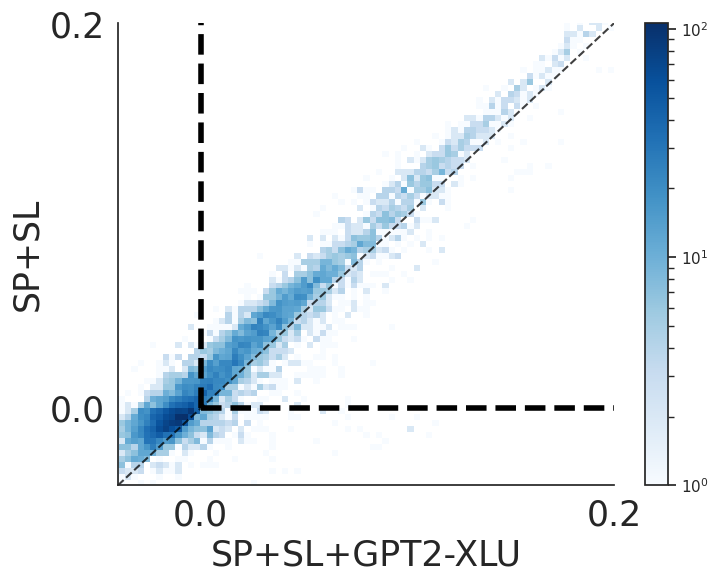

0.88**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ax.get_xlim(), ax.get_ylim(), 'r--', alpha=0.75, color='black')


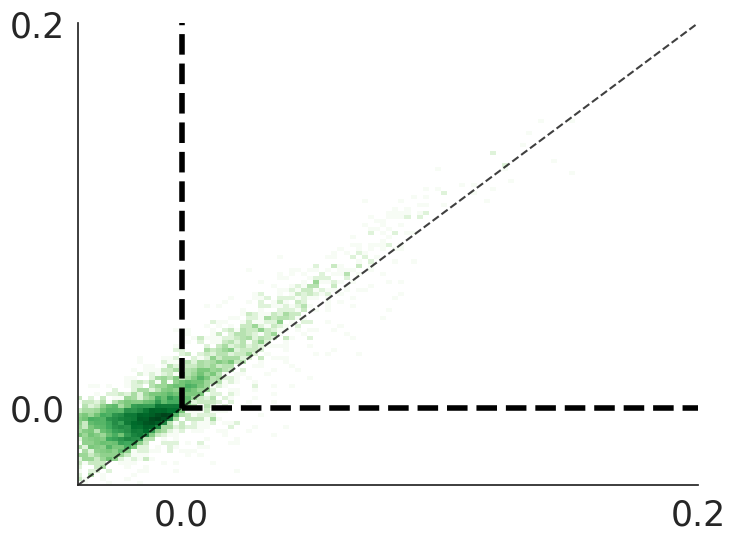

0.729**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ax.get_xlim(), ax.get_ylim(), 'r--', alpha=0.75, color='black')


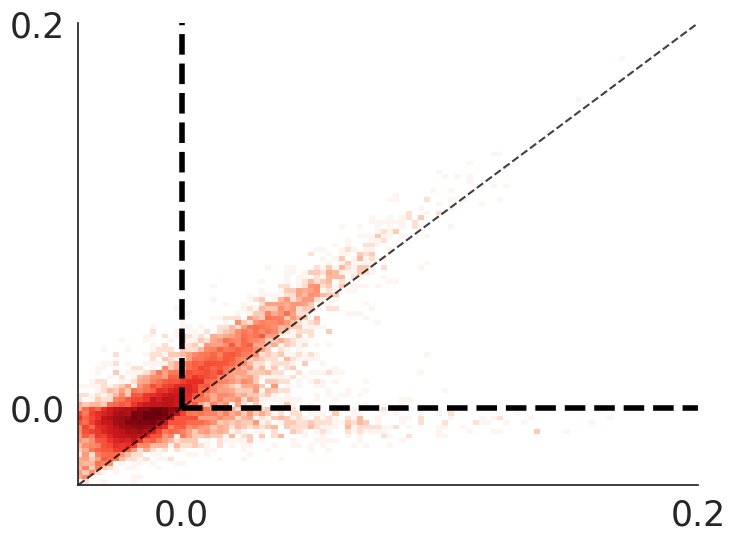

0.881**
FLIPPED


/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/plotting_functions.py:492: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  ax.plot(ax.get_xlim(), ax.get_ylim(), 'r--', alpha=0.75, color='black')


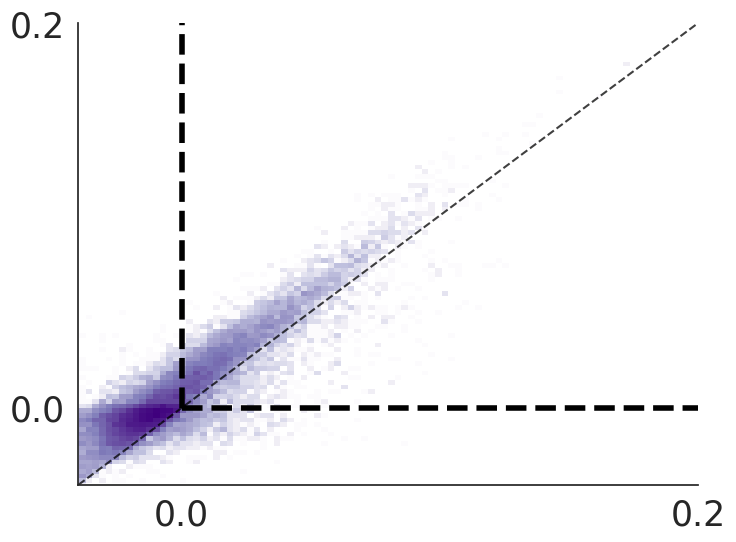

In [17]:
pass_info_plot_hist2d(max_val_dict={'language': 0.20, 'DMN': 0.20, 'MD':0.20, 'visual': 0.20}, 
                      min_val=-0.04, df=r2_stacked_pd_243, best_DEM_model=best_DEM_model, best_LLM_model=best_LLM_model, 
                      figurePath=figurePath, saveName='scatter_243_xl_ut')

### Significant testing perf voxel

In [17]:
pvals_243_BLPW_PW = compute_p_val('243', num_vox_dict, mse_bil_PW_243, mse_PW_243)
pvals_384_BLPW_PW = compute_p_val('384', num_vox_dict, mse_bil_PW_384, mse_PW_384)
pvals_243_BLPW_PW = pvals_243_BLPW_PW[non_nan_243]
pvals_384_BLPW_PW = pvals_384_BLPW_PW[non_nan_384]
pvals_pd_243 = arrange_pvals_pd(pvals_243_BLPW_PW, '243', subjects_dict, br_labels_dict, non_nan_243)
pvals_pd_384 = arrange_pvals_pd(pvals_384_BLPW_PW, '384', subjects_dict, br_labels_dict, non_nan_384)
psig_384_before_fdr = pvals_pd_384.loc[pvals_pd_384.pvals < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_384_after_fdr = pvals_pd_384.loc[pvals_pd_384.pvals_adj < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_243_before_fdr = pvals_pd_243.loc[pvals_pd_243.pvals < 0.05].shape[0]/len(pvals_pd_243) * 100
psig_243_after_fdr = pvals_pd_243.loc[pvals_pd_243.pvals_adj < 0.05].shape[0]/len(pvals_pd_243) * 100
print("384", psig_384_before_fdr, psig_384_after_fdr)
print("243", psig_243_before_fdr, psig_243_after_fdr)

384 1.2559853864695139 0.0010808824324178257
243 1.4242928452579036 0.07820299500831947


In [18]:
pvals_pd_384 = pvals_pd_384.loc[pvals_pd_384.network=='language']
pvals_pd_243 = pvals_pd_243.loc[pvals_pd_243.network=='language']
psig_384_before_fdr = pvals_pd_384.loc[pvals_pd_384.pvals < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_384_after_fdr = pvals_pd_384.loc[pvals_pd_384.pvals_adj < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_243_before_fdr = pvals_pd_243.loc[pvals_pd_243.pvals < 0.05].shape[0]/len(pvals_pd_243) * 100
psig_243_after_fdr = pvals_pd_243.loc[pvals_pd_243.pvals_adj < 0.05].shape[0]/len(pvals_pd_243) * 100
print("384", psig_384_before_fdr, psig_384_after_fdr)
print("243", psig_243_before_fdr, psig_243_after_fdr)

384 1.8291175743593968 0.0
243 1.3323371933756691 0.0


# Voxel-wise corrections, Figure 2c, d

In [19]:
BL_mod_384, non_BL_mod_384, full_mod_384 = \
            voxel_corrected_LLM_nested_full(r2_stacked_pd_384, LLM_name, best_DEM_model, best_LLM_model)

/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/untrained_results_funcs.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = np.clip(df['r2'], a_min=0, a_max=None)


In [20]:
BL_mod_243, non_BL_mod_243, full_mod_243 = \
            voxel_corrected_LLM_nested_full(r2_stacked_pd_243, LLM_name, best_DEM_model, best_LLM_model)

/home3/ebrahim/what-is-brainscore/analyze_results/figures_code/untrained_results_funcs.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r2'] = np.clip(df['r2'], a_min=0, a_max=None)


In [21]:
mse_PW_384_concat = mse_max_model(np.stack((mse_W_384, mse_P_384, mse_PW_384))[:, :, non_nan_384])
mse_bil_PW_384_concat = mse_max_model(np.stack((mse_bil_384, mse_bil_W_384, mse_bil_P_384, mse_bil_PW_384))[:, :, non_nan_384])

mse_PW_243_concat = mse_max_model(np.stack((mse_W_243, mse_P_243, mse_PW_243))[:, :, non_nan_243])
mse_bil_PW_243_concat = mse_max_model(np.stack((mse_bil_243, mse_bil_W_243, mse_bil_P_243, mse_bil_PW_243))[:, :, non_nan_243])

### significance tests after voxel-wise corrections

In [21]:
pvals_243_BLPW_PW = compute_p_val('243', num_vox_dict, mse_bil_PW_243_concat.T, mse_PW_243_concat.T)
pvals_384_BLPW_PW = compute_p_val('384', num_vox_dict, mse_bil_PW_384_concat.T, mse_PW_384_concat.T)
pvals_pd_243 = arrange_pvals_pd(pvals_243_BLPW_PW, '243', subjects_dict, br_labels_dict, non_nan_243)
pvals_pd_384 = arrange_pvals_pd(pvals_384_BLPW_PW, '384', subjects_dict, br_labels_dict, non_nan_384)
psig_384_before_fdr = pvals_pd_384.loc[pvals_pd_384.pvals < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_384_after_fdr = pvals_pd_384.loc[pvals_pd_384.pvals_adj < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_243_before_fdr = pvals_pd_243.loc[pvals_pd_243.pvals < 0.05].shape[0]/len(pvals_pd_243) * 100
psig_243_after_fdr = pvals_pd_243.loc[pvals_pd_243.pvals_adj < 0.05].shape[0]/len(pvals_pd_243) * 100
print("384", psig_384_before_fdr, psig_384_after_fdr)
print("243", psig_243_before_fdr, psig_243_after_fdr)

384 1.006301544580996 0.0
243 1.1813643926788686 0.05158069883527454


In [74]:
pvals_pd_384 = pvals_pd_384.loc[pvals_pd_384.network=='language']
pvals_pd_243 = pvals_pd_243.loc[pvals_pd_243.network=='language']
psig_384_before_fdr = pvals_pd_384.loc[pvals_pd_384.pvals < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_384_after_fdr = pvals_pd_384.loc[pvals_pd_384.pvals_adj < 0.05].shape[0]/len(pvals_pd_384) * 100
psig_243_before_fdr = pvals_pd_243.loc[pvals_pd_243.pvals < 0.05].shape[0]/len(pvals_pd_243) * 100
psig_243_after_fdr = pvals_pd_243.loc[pvals_pd_243.pvals_adj < 0.05].shape[0]/len(pvals_pd_243) * 100
print("384", psig_384_before_fdr, psig_384_after_fdr)
print("243", psig_243_before_fdr, psig_243_after_fdr)

384 1.2606080580044492 0.0
243 0.9463329597808492 0.0


In [22]:
modified_384 = pd.concat((non_BL_mod_384, full_mod_384))
modified_243 = pd.concat((non_BL_mod_243, full_mod_243))

In [37]:
def return_frac_var_explained(submodel, submodel_with_LLM, LLM_perf):
    
    submodel = submodel.loc[submodel.Network=='language']
    submodel_with_LLM = submodel_with_LLM.loc[submodel_with_LLM.Network=='language']
    LLM_perf = LLM_perf.loc[LLM_perf.Network=='language']
    LLM_perf = LLM_perf.groupby(['subjects']).r2.mean().values
    numerator = submodel_with_LLM.groupby(['subjects']).r2.mean().values - submodel.groupby(['subjects']).r2.mean().values
    
    fve = np.clip(1 - (numerator/LLM_perf), 0, 1)
    print(np.mean(fve), np.std(fve)/np.sqrt(LLM_perf.shape[0]))
    return fve

In [38]:
return_frac_var_explained(non_BL_mod_384, full_mod_384, BL_mod_384)

0.984228957336367 0.014869081618449707


array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.85806062])

In [39]:
return_frac_var_explained(non_BL_mod_243, full_mod_243, BL_mod_243)

1.0 0.0


array([1., 1., 1., 1., 1., 1.])

In [34]:
return_frac_var_explained(non_BL_mod_243, full_mod_243, BL_mod_243)

1.6287852628681143 0.17534692229944543


array([1.34472223, 2.08985226, 1.84650017, 1.18577032, 2.18621216,
       1.11965443])

In [24]:
default_palette = sns.color_palette("deep")
default_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

<Figure size 640x480 with 0 Axes>

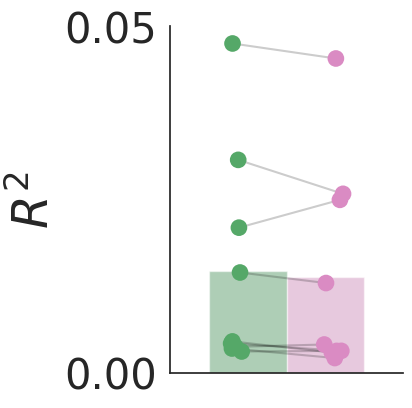

In [25]:
_, _, _ = plot_across_subjects(modified_384.copy(), figurePath=figurePath, selected_networks=['language'],
                                             saveName='384_across_subjects_xl_untrained_mod', hue_order=[best_DEM_model, best_LLM_model], 
                                             yticks=[0,0.05], order=['language'], clip_zero=True, color_palette=[default_palette[2], 
                                             default_palette[6]], draw_lines=True, ms=12, width=0.67, figsize=[3,4.5])

<Figure size 640x480 with 0 Axes>

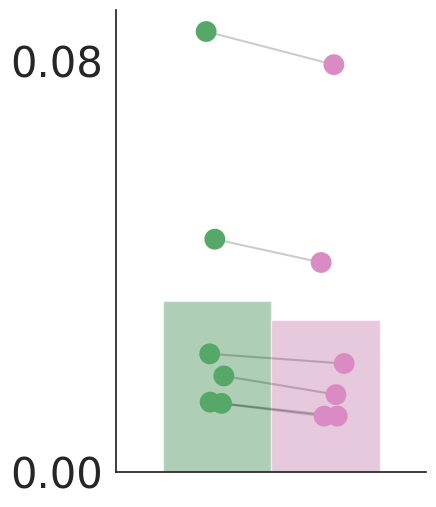

In [78]:
_, _, _ = plot_across_subjects(modified_243.copy(), figurePath=figurePath, selected_networks=['language'],
                                             saveName='243_across_subjects_xl_untrained_mod', hue_order=[best_DEM_model, best_LLM_model], 
                                             yticks=[0,0.08], 
                                                order=['language'], clip_zero=True, color_palette=[default_palette[2], default_palette[6]], draw_lines=True, ms=12,
                                                ylabel=False, width=0.67, figsize=[3,4.5])

In [80]:
PW_corrected_r2_243 = modified_243.loc[modified_243.Model=='SP+SL'].r2.values
BLPW_corrected_r2_243 = modified_243.loc[modified_243.Model=='SP+SL+GPT2-XLU'].r2.values

plotting_folder = "/data/LLMs/Pereira/plotting_data/"
subjects, stored_data_exp_WN_pos = save_fMRI_simple(PW_corrected_r2_243, exp='243', 
                        subjects_to_plot=np.unique(subjects_dict['243']), 
                        subjects_all=subjects_dict['243'], save_name='SP+SL_243') 

subjects, stored_data_exp_WN_pos = save_fMRI_simple(BLPW_corrected_r2_243, exp='243', 
                        subjects_to_plot=np.unique(subjects_dict['243']), 
                        subjects_all=subjects_dict['243'], save_name='GPT2-XLU+SP+SL_243')

plotting.plot_glass_brain(f'{plotting_folder}SP+SL_243_426.nii', 
                            colorbar=False, display_mode='xz', vmax=0.3, output_file=f'{figurePath}glass_brain_SP+SL_243_426.pdf')
plotting.plot_glass_brain(f'{plotting_folder}GPT2-XLU+SP+SL_426.nii', 
                            colorbar=True, display_mode='xz', vmax=0.3, output_file=f'{figurePath}glass_brain_GPT2-XLU+SP+SL_243_426.pdf')

/home3/ebrahim/miniconda3/envs/llama/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home3/ebrahim/miniconda3/envs/llama/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


In [82]:
PW_corrected_r2_384 = np.clip(modified_384.loc[modified_384.Model=='SP+SL'].r2.values, 0, np.inf)
BLPW_corrected_r2_384 = np.clip(modified_384.loc[modified_384.Model=='SP+SL+GPT2-XLU'].r2.values, 0, np.inf)

plotting_folder = "/data/LLMs/Pereira/plotting_data/"
subjects, stored_data_exp_WN_pos = save_fMRI_simple(PW_corrected_r2_384, exp='384', 
                        subjects_to_plot=np.unique(subjects_dict['384']), 
                        subjects_all=subjects_dict['384'][non_nan_384].squeeze(), save_name='SP+SL_384')

subjects, stored_data_exp_WN_pos = save_fMRI_simple(BLPW_corrected_r2_384, exp='384', 
                        subjects_to_plot=np.unique(subjects_dict['384'][non_nan_384].squeeze()), 
                        subjects_all=subjects_dict['384'][non_nan_384].squeeze(), save_name='GPT2-XLU+SP+SL_384')

plotting.plot_glass_brain(f'{plotting_folder}SP+SL_384_343.nii', 
                            colorbar=False, display_mode='xz',
                            vmax=0.20, output_file=f'{figurePath}glass_brain_SP+SL_384_343.pdf')
plotting.plot_glass_brain(f'{plotting_folder}GPT2-XLU+SP+SL_384_343.nii', 
                            colorbar=True, display_mode='xz',
                            vmax=0.20, output_file=f'{figurePath}glass_brain_GPT2-XLU+SP+SL_384_343.pdf')

/home3/ebrahim/miniconda3/envs/llama/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home3/ebrahim/miniconda3/envs/llama/lib/python3.11/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
